# Hierarchical Bayes Example
### January 6, 2020 


[astroML workshop at the 235th Meeting of the American Astronomical Society](http://www.astroml.org/workshops/AAS235.html)

[Zeljko Ivezic, University of Washington](http://faculty.washington.edu/ivezic/) 

[This notebook](https://github.com/astroML/astroML-workshop_AAS235/blob/master/bayesian/AAS2019_HBexample.ipynb)

##### Resources for this notebook include:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.  
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:

- [Mario Juric: Frequentist vs. Bayesian Perspectives (LSSTC Data Science Fellowship Program Lecture)](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/master/Session4/Day1)
- [Jake VanderPlas: ``Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)
- [Hogg, Bovy and Lang: ``Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686)


##### For those who want to dive deep:

- [D. Sivia and J. Skilling: ``Data Analysis: A Bayesian Tutorial''](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)
- [E.T. Jaynes: ``Probability Theory: The Logic of Science''](http://bayes.wustl.edu/etj/prob/book.pdf)
- [E.T. Jaynes: ``Confidence Intervals vs. Bayesian intervals''](http://bayes.wustl.edu/etj/articles/confidence.pdf)



## Hierarchical Bayes Modeling

(a.k.a. multilevel models, Bayesian belief networks, or graphical models)


We'll start with a quick reminder of Bayes' Theorem and its implications for today's discussion


<img src="bayes2.jpg" style="height:670px">




### Simple case of Gaussian prior and likelihood  

>  ***Bayes' Theorem:*** $$p(M|D) = \frac{p(D|M)p(M)}{p(D)} $$
  
Let's assume a one-dimensional problem: we measure length (or mass, or velocity, or metallicity, or ...) $x$, with measurement uncertainty $e$, and we are trying to estimate $\mu$, the true length. 

We have prior information (belief) for the value of $\mu$ that can be summarized as N($\mu_0$, $\sigma_0$). For example, this could be the result of a number of older (prior) measurements. 


### Simple case of Gaussian prior and likelihood  

>  ***Bayes' Theorem:*** $$p(M|D) = \frac{p(D|M)p(M)}{p(D)} $$



The posterior probability density function is then 

$$ p(\mu | x, e, \mu_0, \sigma_0) \propto \frac{1}{e\sqrt{2\pi}} \exp\left(\frac{-(\mu - x)^2}{2e^2}\right) \times$$
$$ \frac{1}{\sigma_0\sqrt{2\pi}} \exp\left(\frac{-(\mu - \mu_0)^2}{2 \sigma_0^2}\right).$$




When the posterior probability density function is a product of two Gaussians, 
it is easy to show that $ p(\mu | x, e, \mu_0, \sigma_0)$ can be summarized as a Gaussian
$$ p(\mu | x, e, \mu_0, \sigma_0) = \frac{1}{\sigma_p\sqrt{2\pi}} \exp\left(\frac{-(\mu - \mu_p)^2}{2\sigma_p^2}\right),$$

with 
$$\mu_p = \frac{(x/e^2) + (\mu_0/\sigma_0^2)}{1/e^2 + 1/\sigma_0^2}  $$
and 
$$ \sigma_p = \left( 1/e^2 + 1/\sigma_0^2 \right)^{-1/2}$$



### Simple case of Gaussian prior and likelihood  

This result, where $\mu_p$ is obtained by inverse variance weighting, 
$$\mu_p = \frac{(x/e^2) + (\mu_0/\sigma_0^2)}{1/e^2 + 1/\sigma_0^2} \,\,\,\, {\rm and} \,\,\,\, \sigma_p = \left( 1/e^2 + 1/\sigma_0^2 \right)^{-1/2}$$
is quite simple, but very educational. Let's plot an example...

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

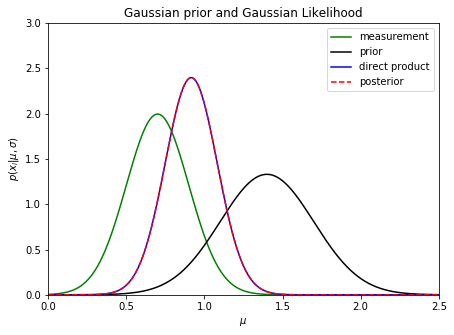

In [2]:
## case of conjugate prior: both prior and posterior pdfs are gaussian
x = 0.7 
e = 0.2
mu0 = 1.4
sigma0 = 0.3 
muGrid = np.linspace(0,3,1000)
n1 = norm(x, e).pdf(muGrid) 
n2 = norm(mu0, sigma0).pdf(muGrid) 
P = n1 * n2 
# need to properly normalize P to make it pdf 
from scipy.integrate import simps
P = P/simps(P, muGrid)

# for fun, compute mu_p and sigma_p and compare to direct multiplication of n1 and n2
sigma_p = 1/np.sqrt(1/e**2+1/sigma0**2)
mu_p = (x/e**2 + mu0/sigma0**2)*sigma_p**2
posterior = norm(mu_p, sigma_p).pdf(muGrid) 

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, n1, ls='-', c='green', label=r'measurement')
plt.plot(muGrid, n2, ls='-', c='black', label=r'prior')
plt.plot(muGrid, P, ls='-', c='blue', label=r'direct product')
plt.plot(muGrid, posterior, ls='--', c='red', label=r'posterior')


plt.xlim(0.0, 2.5)
plt.ylim(0, 3.0)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Gaussian prior and Gaussian Likelihood')
plt.legend()
plt.show() 
 

- The posterior pdf is ***narrower*** than both measurement pdf (i.e. likelihood) and prior pdf (recall that measurement precision often scales as $1/\sqrt{N}$, where $N$ is the number of data points)

- The posterior pdf is ***biased*** compared to the maximum likelihood estimate! 

- In this example, the likelihood and prior pdfs can be switched and the posterior pdf will remain unchanged

- The same posterior pdf is the solution when prior is based on $N-1$ data points and likelihood corresponds to the $N$th data point: an online algorithm! 

#### Let's now assume we have N measurements (data points)

### Estimating parameters of a Gaussian distribution using data with homoscedastic Gaussian uncertainties

The data likelihood can be written as:

$$  p(\{x_i\}|\mu,\sigma,I) = \prod_{i=1}^N  {1 \over \sqrt{2\pi} (\sigma^2+e^2)^{1/2}}
                   \exp{\left({-(x_i-\mu)^2 \over 2 (\sigma^2+e^2)}\right)}$$
                   
Here, $\mu$ and $\sigma$ can still describe the prior pdf. But we can also interpret 
it as an additional (part of the) process that generates data, with $\mu$ and $\sigma$
model parameters describing that process, and themselves drawn from flat priors - math
is exactly the same. 

Because errors are homoscedastic (all data points have uncertainty $e$), there is a
closed-form solution. For example, we can estimate $\sigma^2$ by subtracting $e^2$ from
the variance of $\{x_i\}$ (i.e. if $\sigma=$, the width of $\{x_i\}$ distribution would be simply $e$).

#### Here is another relatively simple case to bring us closer to the main idea of Hierarchical Bayes: 

### Estimating parameters of a Gaussian distribution using data with heteroscedastic Gaussian uncertainties

The data likelihood can be written as:

$$  p(\{x_i\}|\mu,\sigma,I) = \prod_{i=1}^N  {1 \over \sqrt{2\pi} (\sigma^2+e_i^2)^{1/2}}
                   \exp{\left({-(x_i-\mu)^2 \over 2 (\sigma^2+e_i^2)}\right)}$$

There is no closed-form solution here because errors are heteroscedastic (each data point
has a different uncertainty $e_i$), but we can easily evaluate posterior pdf (say, with uniform priors)
on a grid of $\mu$ and $\sigma$ (or use more sophisticated methods such as MCMC). 

The key point is that the scatter of $\{x_i\}$ is larger than it would be for $\sigma=0$ (that is, $\chi^2>1$)
and thus it constrains $\sigma$. 

### An astrophysical example: radial velocity dispersion for a cluster

Consider measurements of the radial velocities of $N$ stars from a stellar or
galaxy cluster. 

Assume that the cluster radial velocity distribution can be 
fully characterized by its mean, the systemic velocity (because the whole 
cluster is moving relative to the observer), and its standard deviation, 
the cluster velocity dispersion (because objects are gravitationally tied to 
the cluster and have orbital motions). 

The observed dispersion (i.e. standard deviation) of measured velocities 
is always larger than the cluster velocity dispersion because of measurement
errors.  

When measurement errors are homoscedastic, we can estimate the cluster velocity 
dispersion, by subtracting the measurement error contribution from the observed
dispersion (i.e. standard deviation) of measured velocities. 

### An astrophysical example: radial velocity dispersion for a cluster

When measurement errors are heteroscedastic, we don't have a closed-form solution.

We can assume that the true radial velocity of a single object is drawn
from a Gaussian described by $\mu$ (systemic velocity) and $\sigma$ (velocity
dispersion). 

In case of many objects, they will collectively constrain $\mu$ and $\sigma$.
Many independent measurement sets (here a set of one measurement per object) 
that share same priors constrain them better together than can any single 
measurement alone. 


### Hierarchical Bayes 

In hierarchical, or multilevel, Bayesian analysis a prior distribution depends 
on unknown variables, the hyperparameters, that describe the group (population) 
level probabilistic model. 

Their priors, called hyperpriors, resemble the priors in simple (single-level) 
Bayesian models. 

In the radial velocity example above, $\mu$ and $\sigma$ are priors, and their 
corresponding prior distributions (assumed flat below), are hyperpriors. 

When there are many independent measurement sets that share same $\sigma$, 
they constrain it better together than can any single measurement alone. 

In statistics, this effect is known as borrowing strength and is related to 
the concept of shrinkage estimators. 

Let's now look at our radial velocity example numerically. 

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

In [4]:
def gaussgauss_logL(xi, ei, mu, sigma):
    """Equation 5.63: gaussian likelihood with gaussian errors"""
    ndim = len(np.broadcast(sigma, mu).shape)

    xi = xi.reshape(xi.shape + tuple(ndim * [1]))
    ei = ei.reshape(ei.shape + tuple(ndim * [1]))

    s2_e2 = sigma ** 2 + ei ** 2
    return -0.5 * np.sum(np.log(s2_e2) + (xi - mu) ** 2 / s2_e2, 0)

def getExpStD(x, p):
    """given p(x), compute expectation value and std. dev."""
    Ex = np.sum(x * p) / np.sum(p)
    Sx = np.sqrt(np.sum((x - Ex) ** 2 * p) /  np.sum(p))
    return Ex, Sx

In [5]:
# ------------------------------------------------------------
np.random.seed(2)    # for repeatability

N = 10               # number of measured stars
mu_true = -50.0      # km/s, true systemic velocity
sigma_true = 20.0    # km/s, true velocity dispersion
ei = 10 + 40 * np.random.random(N)   # n.b. heteroscedastic errors
# generate measurements
xi = np.random.normal(mu_true, np.sqrt(sigma_true ** 2 + ei ** 2))
wi = 1 / ei ** 2 / np.sum(1 / ei ** 2)
# weighted mean
wmean = np.sum(wi * xi)
# uncertainty of weighted mean
wmeane = 1 / np.sqrt(np.sum(1 / ei ** 2))
# other stats
medvel = np.median(xi)
meanvel = np.mean(xi)
velstd = np.std(xi)

# define the grids and compute logL
sigma = np.linspace(0.01, 120, 70)
mu = np.linspace(-150, 50, 70)

logL = gaussgauss_logL(xi, ei, mu, sigma[:, np.newaxis])
logL -= logL.max()
L = np.exp(logL)

p_sigma = L.sum(1)
p_sigma /= (sigma[1] - sigma[0]) * p_sigma.sum()

p_mu = L.sum(0)
p_mu /= (mu[1] - mu[0]) * p_mu.sum()

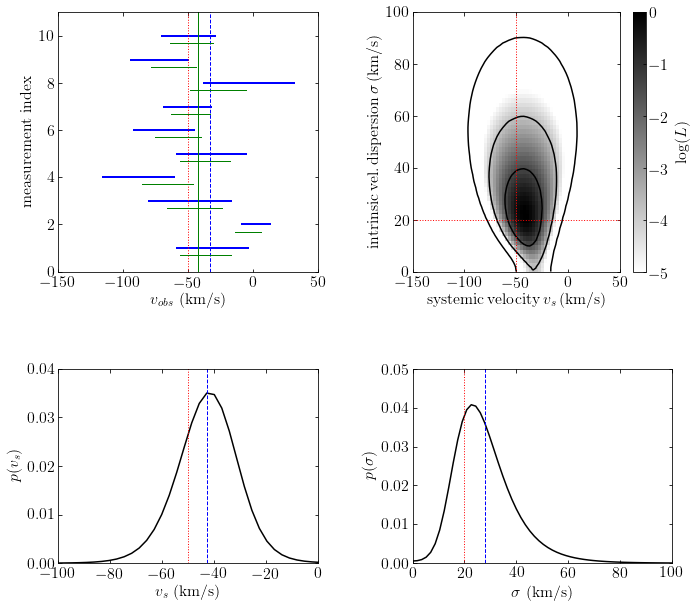

In [6]:
#------------------------------------------------------------
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=16, usetex=True)

# plot the results
fig = plt.figure(figsize=(12, 9.0))

fig.subplots_adjust(left=0.1, right=0.95, wspace=0.24,
                    bottom=0.15, top=0.9)

fig.add_axes((0.58, 0.55, 0.30, 0.40))

plt.imshow(logL, origin='lower',
           extent=(mu[0], mu[-1], sigma[0], sigma[-1]),
           cmap=plt.cm.binary,
           aspect='auto')
plt.colorbar().set_label(r'$\log(L)$')
plt.clim(-5, 0)

plt.contour(mu, sigma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='k')

plt.xlabel(r'${\rm systemic \, velocity \, } v_s \, {\rm (km/s)}$')
plt.ylabel(r'${\rm intrinsic \, vel. \, dispersion \,} \sigma \, {\rm (km/s)}$')
plt.xlim(-150, 50.0)
plt.ylim(0, 100)

# plot true values
plt.plot([mu_true, mu_true], [0, 100.0], ':r', lw=1)
plt.plot([-200, 200.0], [sigma_true, sigma_true], ':r', lw=1)

# second axis: marginalized over mu
ax2 = fig.add_axes((0.17, 0.1, 0.3, 0.30))
ax2.plot(mu, p_mu, '-k', label='')
ax2.set_xlabel(r'$v_s$ (km/s)')
ax2.set_ylabel(r'$p(v_s)$')
ax2.set_xlim(-100, 0.0)
ax2.set_ylim(0, 0.04)
plt.plot([mu_true, mu_true], [0, 100.0], ':r', lw=1)
Ev, Sv = getExpStD(mu, p_mu)
plt.plot([Ev, Ev], [0, 100.0], '--b', lw=1)

# plot the marginalized distribution for sigma
ax3 = fig.add_axes((0.58, 0.1, 0.3, 0.30))
ax3.plot(sigma, p_sigma, '-k', label='')
ax3.set_xlabel(r'$\sigma$ (km/s)')
ax3.set_ylabel(r'$p(\sigma)$')
ax3.set_xlim(0, 100.0)
ax3.set_ylim(0, 0.05)
plt.plot([sigma_true, sigma_true], [0, 100.0], ':r', lw=1)
Ed, Sd = getExpStD(sigma, p_sigma)
plt.plot([Ed, Ed], [0, 100.0], '--b', lw=1)

# plot data
ax4 = fig.add_axes((0.17, 0.55, 0.3, 0.40))
ax4.set_xlabel(r'$v_{obs}$ (km/s)')
ax4.set_ylabel(r'measurement index')
ax4.set_xlim(-150, 50)
ax4.set_ylim(0, 11)
# mark +-error ranges
for i in range(0, N):
    xL = xi[i] - ei[i]
    xR = xi[i] + ei[i]
    plt.plot([xL, xR], [i + 1, i + 1], 'b', lw=2)
# mark true systemic velocity and weighted mean of data
plt.plot([wmean, wmean], [0, 100.0], '--b', lw=1)
plt.plot([mu_true, mu_true], [0, 100.0], ':r', lw=1)

# mark posterior range for each star
mup = Ev
sigp = Ed
for i in range(0, N):
    sig0 = 1 / np.sqrt(1 / sigp ** 2 + 1 / ei[i] ** 2)
    mu0 = (mup / sigp ** 2 + xi[i] / ei[i] ** 2) * (sig0 ** 2)
    xL = mu0 - sig0
    xR = mu0 + sig0
    plt.plot([xL, xR], [i + 0.7, i + 0.7], 'g', lw=1)

# and expectation value for systemic velocity
plt.plot([mup, mup], [0, 100.0], 'g', lw=1)

plt.show()

## Discussion

In this particular example, the cluster velocity dispersion is astrophysically the most interesting quantity, while the posterior constraints on radial velocities for individual stars are less important. 

However, in other settings described by the same mathematical model the posterior pdfs for the individually measured quantities (i.e., the true radial velocity for each star in the above example) may be of more interest than the priors. In such cases the posterior pdf is marginalized over the priors. 

An approximate shortcut approach is to fix the priors at their most probable or expectation values. This method is known as empirical Bayes. 

Note that the posterior estimates of true velocities are biased relative to ML estimates,
and have _smaller_ uncertainies than their measurement uncertainties! 

## Discussion

Recently, HB modeling has become an increasingly popular subfield of astrostatistics. 

HB modeling in astronomy is often applied to a set of sets of measurements that have 
something in common, such as measurements of individual phenomena that come from the 
same population (c.f. the above radial velocity example). Good examples are measurements  
of faint sources that share the same background, of individual supernova luminosities
drawn from a population of cosmological type Ia supernovae, estimates of spectral energy 
distribution of stars that are all behind the same dust layer with unknown extinction 
properties, and estimates of planetary orbital eccentricity distribution. 

Another very important application of HB modeling, that is becoming more common, is 
accounting for measurement errors, intrinsic variance across a population, and various 
astronomical selection effects; a rather complex modeling framework is discussed in detail 
in a landmark study by Kelly et al. 2007 (ApJ 665, 1489). 

